In [1]:
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.applications import vgg16
from tensorflow.keras.optimizers import Adam, SGD
import scipy  #Used to upsample our image

import os
import cv2
from PIL import Image
import numpy as np

from sklearn.model_selection import train_test_split

from winsound import Beep

In [2]:
import tensorflow as tf

gpus = tf.config.experimental.list_physical_devices('GPU')
print(gpus)
if gpus:
  try:
    # Set the GPU as the default device
    tf.config.experimental.set_memory_growth(gpus[0], True)

    tf.config.experimental.set_visible_devices(gpus[0], 'GPU')

  except RuntimeError as e:
    print(e)

print('Memory:' ,tf.config.experimental.get_memory_info('GPU:0')['current'])

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Memory: 0


In [3]:

defect_path = 'DATA/defects/all/images'
normal_path = 'DATA/normal/all/images'

size = 128

def load_dataset(defect_path, normal_path, size=256):
    images_temp = []
    labels_temp = []
    for file in os.listdir(defect_path):
        img = Image.open(os.path.join(defect_path, file))
        img = img.resize((size, size))  
        img = np.array(img) / 255.0  
        images_temp.append(img)
        labels_temp.append(1)  

    for file in os.listdir(normal_path):
        img = Image.open(os.path.join(normal_path, file))
        img = img.resize((size, size))  
        img = np.array(img) / 255.0  
        images_temp.append(img)
        labels_temp.append(0) 

    return np.array(images_temp), np.array(labels_temp)

dataset, labels = load_dataset(defect_path, normal_path, size)
Beep(1600, 800)

In [10]:
dataset.shape

(3103, 128, 128, 3)

In [4]:
X_train, X_val, y_train, y_val = train_test_split(dataset, labels, test_size = 0.15)
print(X_train.shape, X_val.shape)

(2637, 128, 128, 3) (466, 128, 128, 3)


In [5]:
from tensorflow.keras.utils import to_categorical
y_train = to_categorical(y_train)
y_val = to_categorical(y_val)

In [6]:
def get_model(input_shape = (224,224,3)):
    
    vgg = vgg16.VGG16(weights='imagenet', include_top=False, input_shape = input_shape)

    #for layer in vgg.layers[:-8]:  #Set block4 and block5 to be trainable. 
    for layer in vgg.layers[:-5]:    #Set block5 trainable, all others as non-trainable
        print(layer.name)
        layer.trainable = False #All others as non-trainable.

    x = vgg.output
    x = GlobalAveragePooling2D()(x) #Use GlobalAveragePooling and NOT flatten. 
    x = Dense(2, activation="softmax")(x)  #We are defining this as multiclass problem. 

    model = Model(vgg.input, x)
    model.compile(loss = "categorical_crossentropy", 
                  optimizer = SGD(lr=0.0001, momentum=0.9), metrics=["accuracy"])
    
    return model

model = get_model(input_shape = (size,size,3))
print(model.summary())

input_1
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_pool
block4_conv1
block4_conv2
block4_conv3
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 128, 128, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 128, 128, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 64, 64, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 64, 64, 128)       73856     
                                                                 
 block2_conv2 (Conv

c:\Users\ataka\anaconda3\envs\ml\lib\site-packages\keras\optimizers\optimizer_v2\gradient_descent.py:111: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [7]:
history = model.fit(X_train, y_train, batch_size=1, epochs=100, verbose = 1, 
                    validation_data=(X_val,y_val))

Epoch 1/100
2637/2637 [==============================] - 41s 12ms/step - loss: 0.4015 - accuracy: 0.8142 - val_loss: 0.2655 - val_accuracy: 0.9013
Epoch 2/100
2637/2637 [==============================] - 31s 12ms/step - loss: 0.2436 - accuracy: 0.9078 - val_loss: 0.2307 - val_accuracy: 0.9034
Epoch 3/100
2637/2637 [==============================] - 31s 12ms/step - loss: 0.2082 - accuracy: 0.9215 - val_loss: 0.2226 - val_accuracy: 0.9099
Epoch 4/100
2637/2637 [==============================] - 31s 12ms/step - loss: 0.1903 - accuracy: 0.9261 - val_loss: 0.2366 - val_accuracy: 0.9013
Epoch 5/100
2637/2637 [==============================] - 31s 12ms/step - loss: 0.1767 - accuracy: 0.9344 - val_loss: 0.2531 - val_accuracy: 0.9077
Epoch 6/100
2637/2637 [==============================] - 31s 12ms/step - loss: 0.1604 - accuracy: 0.9401 - val_loss: 0.1740 - val_accuracy: 0.9313
Epoch 7/100
2637/2637 [==============================] - 31s 12ms/step - loss: 0.1475 - accuracy: 0.9427 - val_loss: 0

In [8]:
model.save('models/cnn_128_epoch_100')

INFO:tensorflow:Assets written to: models/cnn_128_epoch_100\assets


INFO:tensorflow:Assets written to: models/cnn_128_epoch_100\assets


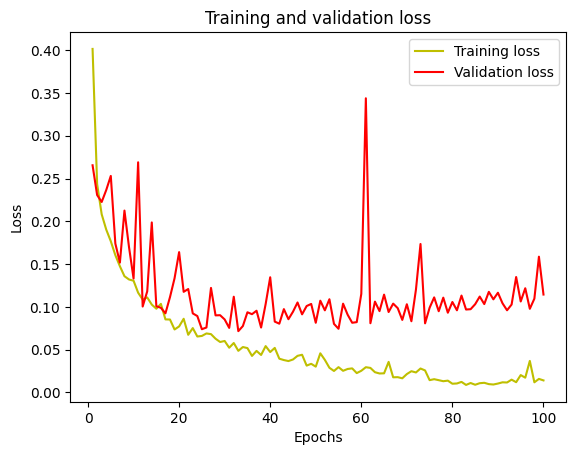

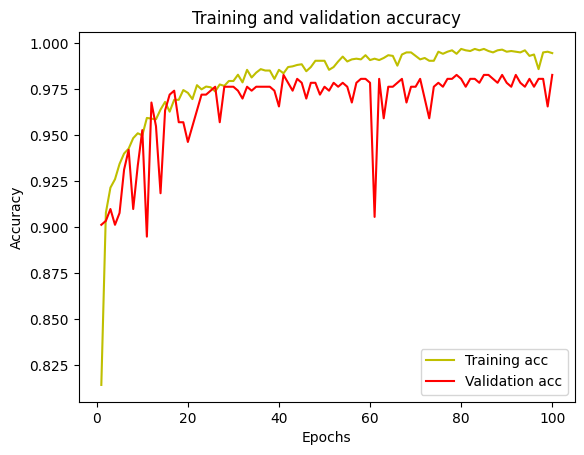

In [9]:
#plot the training and validation accuracy and loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
plt.plot(epochs, acc, 'y', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# PREDICT

In [14]:
# _, acc = model.evaluate(X_test, y_test)
# print("Accuracy = ", (acc * 100.0), "%")

# #Test on single image.
# n=40  #Select the index of image to be loaded for testing
# img = X_test[n]
# plt.imshow(img)
# input_img = np.expand_dims(img, axis=0) #Expand dims so the input is (num images, x, y, c)
# print("The prediction for this image is: ", np.argmax(model.predict(input_img)))
# print("The actual label for this image is: ", np.argmax(y_test[n]))
# model.predict(input_img)

In [22]:
y_pred = np.argmax(model.predict(X_test), axis=1)
y_test = np.argmax(y_test, axis=1)

9/9 [==============================] - 1s 82ms/step


In [23]:
y_pred.shape

(281,)

In [24]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

from sklearn.metrics import f1_score, recall_score, precision_score

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# Calculate F1 score
f1 = f1_score(y_test, y_pred)
print("F1 Score:", f1)

# Calculate Recall
recall = recall_score(y_test, y_pred)
print("Recall:", recall)

# Calculate Precision
precision = precision_score(y_test, y_pred)
print("Precision:", precision)


report = classification_report(y_test, y_pred)
print("Classification Report:\n", report)

conf_mat = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", conf_mat)

Accuracy: 0.9715302491103203
F1 Score: 0.9776536312849162
Recall: 0.9562841530054644
Precision: 1.0
Classification Report:
               precision    recall  f1-score   support

           0       0.92      1.00      0.96        98
           1       1.00      0.96      0.98       183

    accuracy                           0.97       281
   macro avg       0.96      0.98      0.97       281
weighted avg       0.97      0.97      0.97       281

Confusion Matrix:
 [[ 98   0]
 [  8 175]]


9/9 [==============================] - 1s 96ms/step


<Axes: >

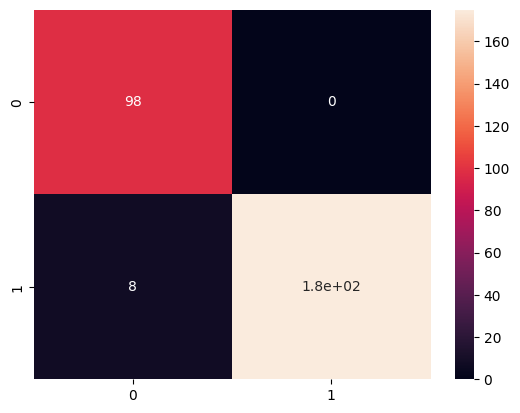

In [26]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

y_pred = np.argmax(model.predict(X_test), axis=1)
cm=confusion_matrix(y_test, y_pred)  
sns.heatmap(cm, annot=True)

# PREDICT ON TEST

In [28]:
defect_path = 'DATA/test/defect'
normal_path = 'DATA/test/normal'

all_defect_path = 'DATA/defects/images'
size = 128


# Load dataset
def load_dataset(defect_path, normal_path, size=256):
    images_temp = []
    labels_temp = []
    for file in os.listdir(defect_path):
        img = Image.open(os.path.join(defect_path, file))
        img = img.resize((size, size))  
        img = np.array(img) / 255.0  
        images_temp.append(img)
        labels_temp.append(1)  

    for file in os.listdir(normal_path):
        img = Image.open(os.path.join(normal_path, file))
        img = img.resize((size, size))  
        img = np.array(img) / 255.0  
        images_temp.append(img)
        labels_temp.append(0) 

    return np.array(images_temp), np.array(labels_temp)

# Split dataset into training and testing sets
images_test, labels_test = load_dataset(defect_path, normal_path, size)

In [29]:
y_pred = np.argmax(model.predict(images_test), axis=1)


7/7 [==============================] - 2s 248ms/step


In [31]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

from sklearn.metrics import f1_score, recall_score, precision_score

accuracy = accuracy_score(labels_test, y_pred)
print("Accuracy:", accuracy)

# Calculate F1 score
f1 = f1_score(labels_test, y_pred)
print("F1 Score:", f1)

# Calculate Recall
recall = recall_score(labels_test, y_pred)
print("Recall:", recall)

# Calculate Precision
precision = precision_score(labels_test, y_pred)
print("Precision:", precision)


report = classification_report(labels_test, y_pred)
print("Classification Report:\n", report)

conf_mat = confusion_matrix(labels_test, y_pred)
print("Confusion Matrix:\n", conf_mat)

Accuracy: 0.975
F1 Score: 0.9743589743589743
Recall: 0.95
Precision: 1.0
Classification Report:
               precision    recall  f1-score   support

           0       0.95      1.00      0.98       100
           1       1.00      0.95      0.97       100

    accuracy                           0.97       200
   macro avg       0.98      0.97      0.97       200
weighted avg       0.98      0.97      0.97       200

Confusion Matrix:
 [[100   0]
 [  5  95]]
